In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

import torch
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/heloc_dataset.csv')
df['RiskPerformance']=(df.RiskPerformance=='Bad')+0

scaler = MinMaxScaler((-1,1))
X = scaler.fit_transform(df.values[:,1:])
y = df['RiskPerformance'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
df

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69
1,1,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0
2,1,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86
3,1,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91
4,1,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10454,0,73,131,5,57,21,0,0,95,80,6,6,21,5,19,7,0,0,26,-8,5,2,0,100
10455,1,65,147,39,68,11,0,0,92,28,6,6,12,0,42,1,1,1,86,53,2,2,1,80
10456,1,74,129,6,64,18,1,1,100,-7,6,8,18,1,33,3,4,4,6,-8,5,-8,0,56
10457,1,72,234,12,113,42,2,2,96,35,6,2,45,0,20,6,0,0,19,-8,4,1,0,38


In [4]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, Y_train)
# train model
bst = xgb.train({'objective':'binary:logistic',
                 'eval_metric':'logloss',
                 'lambda':3}, dtrain, 60)
bst.save_model('adult_black_box.bst')

In [5]:
dtest = xgb.DMatrix(X_test)
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

train acc: 0.8822605965463108
test acc: 0.7045191193511008


In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, X_train, Y_train, X_test, Y_test):
        self.batch_size = batch_size
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test

    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(self.X_train).float(),torch.tensor(self.Y_train,dtype=torch.long).float())
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True) 

    def val_dataloader(self):
        val_dataset = TensorDataset(torch.tensor(self.X_test).float(),torch.tensor(self.Y_test,dtype=torch.long).float())
        return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False) 

class Lit_Dense_Network(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(23, 10)
        self.b1 = nn.BatchNorm1d(10)
        self.fc2 = nn.Linear(10, 5)
        self.b2 = nn.BatchNorm1d(5)
        self.fc3 = nn.Linear(5,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.b1(x)
        x = F.relu(self.fc2(x))
        x = self.b2(x)
        x = F.sigmoid(self.fc3(x))
        return x
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        loss = F.binary_cross_entropy(y_pred, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        loss = F.binary_cross_entropy(y_pred, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [7]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

net = Lit_Dense_Network()
BATCH_SIZE = 1024
dm = DataModule(BATCH_SIZE, X_train, Y_train.reshape(-1,1), X_test, Y_test.reshape(-1,1))
bar = TQDMProgressBar(refresh_rate=20)
es = EarlyStopping(monitor="val_loss", mode="min", patience=5)
logger = TensorBoardLogger("lightning_logs", name="FICO_model", version=1)
trainer = pl.Trainer(callbacks=[bar, es], 
                     max_epochs=100, 
                     log_every_n_steps=10, 
                     logger=logger, 
                     enable_checkpointing=False)

trainer.fit(net, dm)
#trainer.save_checkpoint("fico_black_box.ckpt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type        | Params
-------------------------------------
0 | fc1  | Linear      | 240   
1 | b1   | BatchNorm1d | 20    
2 | fc2  | Linear      | 55    
3 | b2   | BatchNorm1d | 10    
4 | fc3  | Linear      | 6     
-------------------------------------
331       Trainable params
0         Non-trainable params
331       Total params
0.001     Total estimated model params size (MB)


Epoch 37: 100%|██████████| 11/11 [00:00<00:00, 78.33it/s, loss=0.554, v_num=1] 


In [8]:
net = Lit_Dense_Network()
net.eval()
net = net.load_from_checkpoint(checkpoint_path="fico_black_box.ckpt")

In [9]:
from sklearn.metrics import accuracy_score

print(accuracy_score(np.round(net(torch.tensor(X_train).float()).detach().numpy()),Y_train))
print(accuracy_score(np.round(net(torch.tensor(X_test).float()).detach().numpy()),Y_test))

0.7291280148423006
0.7123406720741599


In [10]:
def predict(x, return_proba=False):
    net.eval()
    if return_proba:
        return net(torch.tensor(x).float()).detach().numpy().ravel()
    else: return np.round(net(torch.tensor(x).float()).detach().numpy()).astype(int).ravel()

y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)

In [11]:
X_train = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test,y_test_pred.reshape(-1,1)))

In [37]:
latent_dim = 5
batch_size = 512
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity(X, sigma, idx_cat=None, alpha=1):
    D_features = torch.cdist(X[:,:-1],X[:,:-1])
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    D = D_features + alpha * D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, sigma=1, idx_cat=None ):
    Sx = compute_similarity(X, sigma, idx_cat)
    Sz = compute_similarity(Z, 1)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [38]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/fico_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [39]:
model.load_state_dict(torch.load(f'./models/fico_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

In [40]:
#idx = 2
#plt.scatter(Z_train[:,0],Z_train[:,1],c=y_train_pred,cmap='coolwarm')
#plt.plot(Z_test[idx,0],Z_test[idx,1],'kX',markersize=20)
#plt.grid(True)

In [41]:
idx = 2
pred = predict(X_test[idx:idx+1,:-1], return_proba=True)
pred

array([0.7937927], dtype=float32)

In [42]:
y_contrib = model.fc1.weight[:,-1].detach().numpy()
#plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
#plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
#m = -pred-1
#plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'mX', markersize=20)
#plt.grid()

In [43]:
#import math
#
#p_in = Z_test[idx,:]
#m = -2
#p_fin = Z_test[idx,:]+m*y_contrib
#
#eps = 0.1
#delta = math.sqrt((eps**2)/2)
#
#rule_1 = (Z_train[:,0]-(p_in[0]+delta))/(p_fin[0]-p_in[0])<(Z_train[:,1]-(p_in[1]+delta))/(p_fin[1]-p_in[1])
#rule_2 = (Z_train[:,0]-(p_in[0]-delta))/(p_fin[0]-p_in[0])>(Z_train[:,1]-(p_in[1]-delta))/(p_fin[1]-p_in[1])
#rule_3 = Z_train[:,1]<Z_train[:,0]-p_in[0]+p_in[1]
#rule_4 = Z_train[:,1]>Z_train[:,0]-p_fin[0]+p_fin[1]
#rule = rule_1*rule_2*rule_3*rule_4
#neigh_eps_train = X_train[rule,:]
#
#plt.scatter(Z_train[rule,0], Z_train[rule,1], c=y_train_pred[rule], cmap='coolwarm')
#plt.plot(p_in[0], p_in[1], 'kX', markersize=20)
#plt.plot(p_fin[0], p_fin[1], 'mX', markersize=20)
#plt.grid()
#
#rule_1 = (Z_test[:,0]-(p_in[0]+delta))/(p_fin[0]-p_in[0])<(Z_test[:,1]-(p_in[1]+delta))/(p_fin[1]-p_in[1])
#rule_2 = (Z_test[:,0]-(p_in[0]-delta))/(p_fin[0]-p_in[0])>(Z_test[:,1]-(p_in[1]-delta))/(p_fin[1]-p_in[1])
#rule_3 = Z_test[:,1]<Z_test[:,0]-p_in[0]+p_in[1]
#rule_4 = Z_test[:,1]>Z_test[:,0]-p_fin[0]+p_fin[1]
#rule = rule_1*rule_2*rule_3*rule_4
#neigh_eps_test = X_test[rule,:]
#

In [44]:
#z_neigh_eps_train = model(torch.tensor(neigh_eps_train).float()).detach().numpy()

In [45]:
#cdist(p_in.reshape(1,-1), z_neigh_eps_train)

In [46]:
#cdist(p_in.reshape(1,-1), Z_test)

train acc: 0.9513822688274547
test acc: 0.9161554192229039


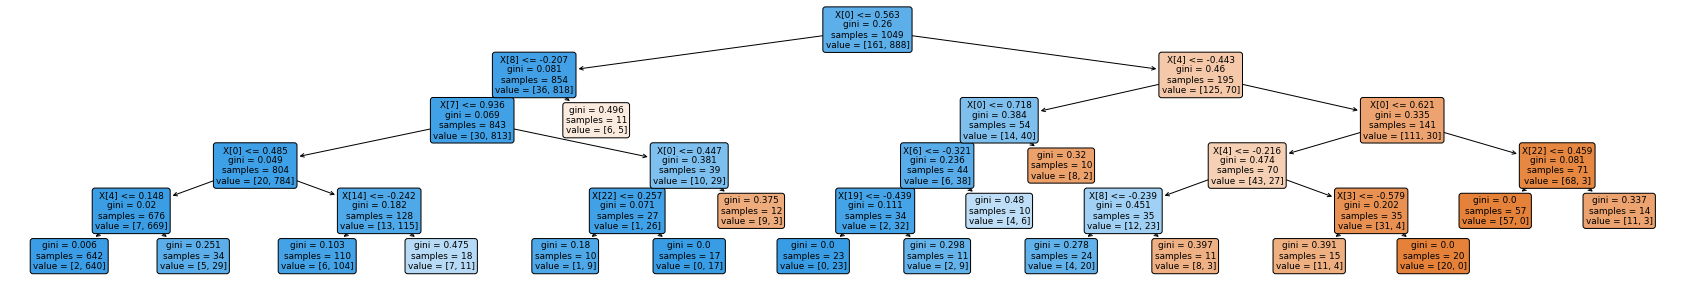

In [344]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn import tree
#
#clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
#clf.fit(neigh_eps_train[:,:-1],np.round(neigh_eps_train[:,-1]))
#plt.figure(figsize=(30,5))
#print('train acc:', clf.score(neigh_eps_train[:,:-1], np.round(neigh_eps_train[:,-1])))
#print('test acc:', clf.score(neigh_eps_test[:,:-1], np.round(neigh_eps_test[:,-1])))
#tree.plot_tree(clf,filled=True,rounded=True);

In [47]:
#q = X_test[idx,:-1].copy()
#pd.DataFrame([q], columns = df.columns[1:])

In [48]:
#print('original:', predict(q.reshape(1,-1),return_proba=True))
#q_mod = q.copy()
#q_mod[0] = 0.7
#q_mod[4] = -0.4
#q_mod[22] = 0.4
#print('mod:', predict(q_mod.reshape(1,-1),return_proba=True))

In [49]:
#q_mod = np.append(q_mod,predict(q_mod.reshape(1,-1)))
#z_q_mod = model(torch.tensor(q_mod).float()).detach().numpy()
#plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
#plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
#m = -pred-1
#plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'mX', markersize=20)
#plt.plot(z_q_mod[0], z_q_mod[1], 'gX', markersize=20)
#plt.grid()

# Counter Exemplars

In [50]:
idx = 2
q = X_test[idx].copy()
pred = predict(q[:-1].reshape(1,-1))
if pred > 0.5:
    m = -pred
else:
    m = 1-pred
v = np.array(Z_test[idx,:]+m*y_contrib)
v

array([ 1.12270784,  0.38490671, -0.23666538,  0.46546501,  0.48622478])

In [51]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()

In [58]:
def compute_cf(q, indexes):
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
    if q_pred > 0.5:
        m = -q_pred+0.3
    else:
        m = 1-q_pred-0.3
    v = np.array(model(torch.tensor(q).float()).detach().numpy()+m*y_contrib)
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        #print(delta_i)
        q_cf[indexes] += delta_i
        q_cf = np.clip(q_cf,-1,1)
        if float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)) in q_cf_preds:
            return q_cf
        q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
        q_cf[-1] = q_cf_preds[-1]
    return q_cf

In [59]:
q = X_test[idx,:].copy()
print(predict(q[:-1].reshape(1,-1),return_proba=True))
q_cf = compute_cf(q, list(range(23)))
q_cf[-1] = predict(q_cf[:-1].reshape(1,-1),return_proba=True) 
print(predict(q_cf[:-1].reshape(1,-1),return_proba=True))
pd.DataFrame([q[:-1],q_cf[:-1]], columns = df.columns[1:])

[0.7937927]
[0.41938344]


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,0.300971,-0.864532,-0.918367,-0.760204,-0.500000,-0.357143,-0.357143,0.87156,-0.630435,0.444444,0.764706,-0.752212,-0.285714,0.082569,-0.878788,-0.706667,-0.706667,-0.261411,-0.612500,-0.317073,-0.187500,-0.259259,0.816514
1,0.610791,-0.729455,-0.949846,-0.586084,-0.342753,-0.487269,-0.501077,1.00000,-0.632320,0.587207,0.899058,-0.671739,-0.308799,-0.059512,-0.707508,-0.838975,-0.843682,-0.525672,-0.637821,-0.405667,-0.178267,-0.216861,0.514968


In [60]:
from scipy.spatial.distance import euclidean, cdist
print(euclidean(q,q_cf))
print(np.min(cdist(q_cf[:-1].reshape(1,-1),X_train[:,:-1])))

0.8166897374787677
0.5364884211369737


In [61]:
from itertools import combinations

q = X_test[idx,:].copy()
q_cfs = []
for i in [1,2,23,22,21]:
    for indexes in  list(combinations(range(23),i)):    
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1), return_proba=True)
        if q_cf_pred<0.5:
            q_cfs.append(q_cf)
        
q_cfs = np.vstack(q_cfs)

In [62]:
q_cfs.shape

(259, 24)

In [63]:
print(np.min(cdist(q_cfs[:,:-1],q[:-1].reshape(1,-1))))
print(np.min(cdist(q_cfs[:,:-1],X_train[:,:-1])))

0.72503875807723
0.4867571068573533


In [64]:
from itertools import combinations
from tqdm.notebook import tqdm

d_dist = []
d_dist_mix = []
d_impl = []
d_impl_mix = []

for idx in tqdm(range(1000)):
    q = X_test[idx,:].copy()
    q_pred = np.round(predict(q[:-1].reshape(1,-1),return_proba=True))
    q_cfs = []
    for i in [1,2,21,22,23]:
        for indexes in  list(combinations(range(23),i)):    
            q_cf = compute_cf(q, list(indexes))
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if q_pred:
                if q_cf_pred < 0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred > 0.5:
                    q_cfs.append(q_cf)
    if len(q_cfs)<1:
        continue
    else:
        q_cfs = np.vstack(q_cfs)
        d_dist.append(np.min(cdist(q_cfs[:,:-1],q[:-1].reshape(1,-1))))
        d_impl.append(np.min(cdist(q_cfs[:,:-1],X_train[:,:-1])))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(np.mean(np.array(d_dist)))
print(np.mean(np.array(d_impl)))

0.5978446684446368
0.5061275979887072


In [ ]:
len(d_dist)

945

# Growing Spheres

In [324]:
from growingspheres import counterfactuals as cf

idx = 0
q = X_test[idx,:-1].reshape(1,-1).copy()
pred = int(predict(q))
print(pred)

CF = cf.CounterfactualExplanation(q, predict, method='GS')
CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=True)
q_cf_GS = CF.enemy
print(predict(q_cf_GS.reshape(1,-1)))

0
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  6
Final radius:  (0.1, 0.11800000000000001)
Final number of ennemies:  6
Feature selection...
Reduced 15 coordinates
[1]


In [325]:
q.shape

(1, 23)

In [326]:
pd.DataFrame(np.vstack([q,q_cf_GS.reshape(1,-1)]), columns = df.columns[:-1])

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization
0,0.514563,-0.6133,-0.933673,-0.617347,0.136364,-0.357143,-0.357143,1.000000,-0.956522,0.777778,1.0,-0.115044,-0.071429,-0.651376,-0.878788,-0.733333,-0.733333,-0.659751,-0.7125,-0.219512,-0.25,-0.259259,0.082569
1,0.479105,-0.6133,-0.900631,-0.617347,0.111826,-0.357143,-0.357143,0.992282,-0.956522,0.777778,1.0,-0.115044,-0.037167,-0.651376,-0.878788,-0.702236,-0.733333,-0.637157,-0.7125,-0.212226,-0.25,-0.259259,0.082569


In [327]:
print(euclidean(q,q_cf_GS))
print(np.min(cdist(q_cf_GS.reshape(1,-1),X_train[:,:-1])))

0.07559916569266054
0.4854960001351001


In [328]:
d_dist_GS = []
d_impl_GS = []

for idx in tqdm(range(1000)):
    q = X_test[idx,:-1].reshape(1,-1).copy()
    CF = cf.CounterfactualExplanation(q, predict, method='GS')
    CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=False)
    q_cf_GS = CF.enemy
    d_dist_GS.append(euclidean(q_cf_GS,q))
    d_impl_GS.append(np.min(cdist(q_cf_GS.reshape(1,-1),X_train[:,:-1])))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [329]:
print(np.mean(np.array(d_dist_GS)))
print(np.mean(np.array(d_impl_GS)))

0.400315160464894
0.6162022254279131
